This notebook tries to replicate what is done [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb)  but in Pytorch.

Reference: [Distill.pub / Differentiable Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer)

In [170]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


import torch

from torchvision import models

import numpy as np

import PIL.Image
import urllib

import matplotlib.pyplot as plt

from visualization.interp import param, vis
from visualization.style_transfer import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Inception V1 is GoogLeNet according to [this](https://pytorch.org/docs/stable/torchvision/models.html#id23)

In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model = models.googlenet(pretrained=True)
model.cuda()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [172]:
def load(url):
    img = PIL.Image.open(urllib.request.urlopen(url))
    return np.array(img)

(512, 512, 3) (512, 645, 3)


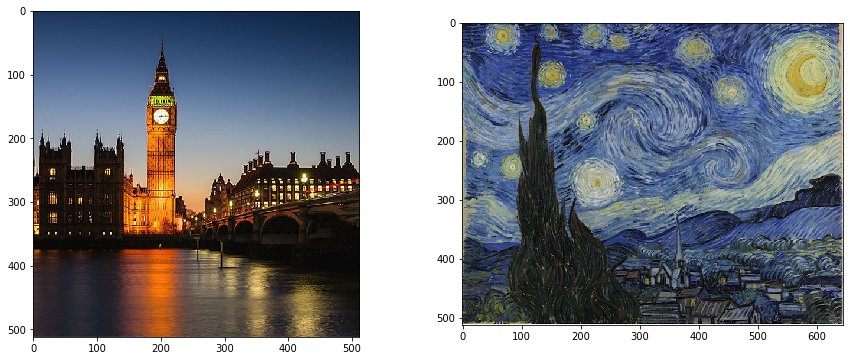

In [173]:
# how to load images from URLs?

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

_, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(content_image)
ax[1].imshow(style_image)

In [174]:
type(content_image)

numpy.ndarray

The InceptionV1 layers from TF are like this: (compare with the Pytorch model)

```
[Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
  Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <head1_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn1: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax1: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax2: 1008> ([{'dense'}])]
 19
 ```
 
 And the layers to plug into are:
 ```
 style_layers = [
  'conv2d2',  # conv3
  'mixed3a',  # inception3a
  'mixed4a',  # inception3b
  'mixed4b',  # inception4b
  'mixed4c',  # inception4c
]

content_layers = [
  'mixed3b',  # inception3b
]
 ```

In [175]:
print('\n'.join(model._modules.keys()))

conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [176]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [177]:
len(model._modules)

19

In [178]:
style_layers = [
  'conv3',
  'inception3a',
  'inception4a',
  'inception4b',
  'inception4c',
]

content_layers = [
  'inception3b',
]

In [195]:
arch = LayeredModule.from_custom_model(model)

In [196]:
from visualization.modules import Normalization

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]) #.to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]) #.to(device)

arch.prepend('normalization', Normalization(cnn_normalization_mean, cnn_normalization_std))

In [197]:
arch

LayeredModule(
  (layers): ModuleDict(
    (normalization): Normalization()
    (transform_input): Lambda()
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Con

In [198]:
list(arch.layers.keys())

['normalization',
 'transform_input',
 'conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'flatten',
 'dropout',
 'fc']

In [199]:
min(content_image.shape[:2])

512

In [200]:
# we need to pre-prend the "layer" of the parameterization

image_param = param.ImageParam(min(content_image.shape[:2]), fft=True, decorrelate=True)

In [201]:
#arch.prepend('image_param', image_param)

In [202]:
import torchvision.transforms as T

from visualization.interp.utils import *

def transform_inputs(content_image, style_image):
    content_tfms = T.ToTensor()
    content_input = content_tfms(content_image).unsqueeze(0)
    # content_input = norm(content_tfms(content_image), input_range=(0, 1), grad=False)
    style_tfms = T.Compose([T.ToPILImage(), T.RandomCrop(content_image.shape[:2]), T.ToTensor()])
    style_input = style_tfms(style_image).unsqueeze(0)
    # style_input = norm(style_tfms(style_image), input_range=(0, 1), grad=False)
    return content_input, style_input

In [203]:
content_input, style_input = transform_inputs(content_image, style_image)

In [204]:
content_input.shape, content_input.max()

content_input = content_input.cuda()
style_input = style_input.cuda()

content_input.device

(torch.Size([1, 3, 512, 512]), tensor(1.))

In [205]:
import torch.nn.functional as F

style_module = StyleTransferModule(arch, content_input, content_layers, style_input, style_layers, loss_func=F.l1_loss)

In [206]:
style_obj = StyleTransferObjective(style_module, style_weight=100, content_weight=1)

In [207]:
style_obj

style_transfer_obj

In [208]:
import torch.optim
from visualization.generation.render import *

optvis = OptVis(style_module, style_obj, optim=optim.LBFGS)

Optimizing for style_transfer_obj


In [ ]:
class STCallback(OptVisCallback):
    def on_step_begin(self, optvis, img, *args, **kwargs):
        img.data.clamp_(0.0, 1.0)

    def on_step_end(self, optvis, img, *args, **kwargs):
        if optvis.run % 50 == 0:
            print(f'Style loss={optvis.objective.style_loss}, Content loss={optvis.objective.content_loss}, TV loss={optvis.objective.tv_loss}')

    def on_render_end(self, optvis, img, *args, **kwargs):
        img.data.clamp_(0.0, 1.0)

stc = STCallback()

In [25]:
import torch
torch.cuda.empty_cache()

In [26]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 6233391104
Free memory: 5176557568
Used memory: 1056833536


In [27]:
torch.cuda.memory_allocated()

241977856

In [210]:
<<<<<<< local
optvis.vis(image_param, thresh=(300,), transform=False, in_closure=True, callback=stc)
=======
optvis.vis(image_param, thresh=(100,), transform=False(, lr=0.05, wd=5.)
>>>>>>> remote

Run [50], loss=0.1951
Style loss=0.0675404742360115, Content loss=0.12753926217556, TV loss=0.0
Run [100], loss=0.1649
Style loss=0.05960856378078461, Content loss=0.10527650266885757, TV loss=0.0
Run [150], loss=0.1538
Style loss=0.057259224355220795, Content loss=0.09654445946216583, TV loss=0.0
Run [200], loss=0.1479
Style loss=0.05596214160323143, Content loss=0.09198538959026337, TV loss=0.0
Run [250], loss=0.1443
Style loss=0.0552402101457119, Content loss=0.08908422291278839, TV loss=0.0
Run [300], loss=0.1416
Style loss=0.05467750504612923, Content loss=0.08694355934858322, TV loss=0.0


tensor([[[[0.4883, 0.2217, 0.1396,  ..., 0.2784, 0.4041, 0.4681],
          [0.1650, 0.1226, 0.1171,  ..., 0.1832, 0.1621, 0.2105],
          [0.1405, 0.1433, 0.0945,  ..., 0.1559, 0.1196, 0.1568],
          ...,
          [0.2015, 0.1465, 0.0736,  ..., 0.0355, 0.0343, 0.1124],
          [0.2091, 0.1031, 0.0553,  ..., 0.0472, 0.0574, 0.1492],
          [0.2345, 0.1919, 0.1357,  ..., 0.1782, 0.2148, 0.2354]],

         [[0.4971, 0.2414, 0.1537,  ..., 0.2906, 0.3914, 0.4419],
          [0.1679, 0.1375, 0.1304,  ..., 0.1985, 0.1514, 0.1931],
          [0.1329, 0.1490, 0.0984,  ..., 0.1523, 0.1013, 0.1330],
          ...,
          [0.1460, 0.0970, 0.0463,  ..., 0.0239, 0.0248, 0.0844],
          [0.1626, 0.0762, 0.0402,  ..., 0.0338, 0.0419, 0.1149],
          [0.2093, 0.1783, 0.1248,  ..., 0.1581, 0.1831, 0.1975]],

         [[0.7564, 0.4975, 0.3426,  ..., 0.6225, 0.6703, 0.6896],
          [0.3823, 0.3302, 0.2947,  ..., 0.5092, 0.3540, 0.3953],
          [0.2672, 0.3037, 0.2022,  ..., 0

In [211]:
import torchvision.transforms as transforms

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


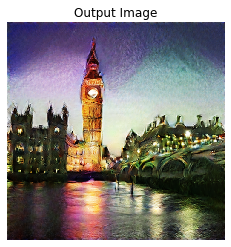

In [212]:
output = image_param()
imshow(output, title='Output Image')

In [213]:
torch.__version__

'1.3.1'

In [214]:
output.shape

torch.Size([1, 3, 512, 512])

In [215]:
output_np = output.squeeze(0).clone().detach().numpy().transpose((1,2,0))

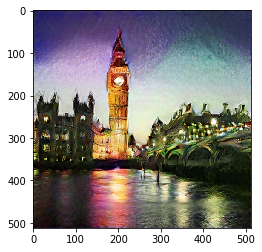

In [216]:
plt.imshow(output_np)